In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# CNN layers and datasets
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D

# Pretrained Models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.initializers import Zeros

from tensorflow.keras.applications.mobilenet_v2 import (
    MobileNetV2,
    preprocess_input,
    decode_predictions,
)


from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split
import seaborn as sns
import glob as glob
import os
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing import image

# There are 6000 images per class with 5000 training and 1000 testing images per class in CIFAR-10.

train data shape = $(50000, 32, 32, 3)
test data shape = $(10000, 32, 32, 3)


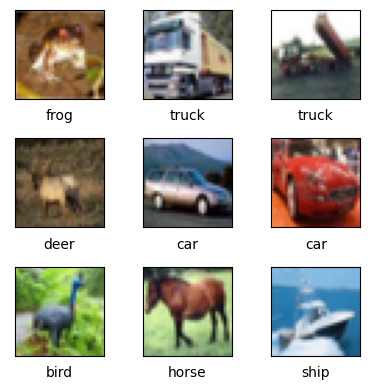

In [3]:
(train_img, train_label), (test_img, test_label) = cifar10.load_data()
train_img, test_img = train_img / 255, test_img / 255

print(f"train data shape = ${train_img.shape}")
print(f"test data shape = ${test_img.shape}")

class_names = [
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
X_test_img, X_valid_img, y_test_label, y_valid_label = train_test_split(
    test_img, test_label, test_size=0.2, random_state=42
)
plt.figure(figsize=(4, 4))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_img[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_label[i][0]])

plt.tight_layout()
plt.show()

Building a basic model of 2 conv layer one maxPooling 2 dense relu layer and 1 softmax layer

In [ ]:
def myModel():
    model = Sequential(
        [
            Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3)),
            MaxPooling2D((2, 2)),  # reduces and simplifies no. of features
            Conv2D(64, (3, 3), activation="relu"),
            MaxPooling2D((2, 2)),
            Flatten(),  # Making it 1d
            Dense(64, activation="relu"),
            Dense(64, activation="relu"),
            Dense(10, activation="softmax"),
        ]
    )
    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    history = model.fit(
        train_img,
        train_label,
        epochs=10,
        batch_size=64,
        validation_data=(X_valid_img, y_valid_label),
    )
    loss, accuracy = model.evaluate(X_test_img, y_test_label)
    print("Test accuracy:", accuracy)
    print("Test loss:", loss)

    y_pred = model.predict(X_test_img)

    # for each sample image in test dataset select class label with highest probability
    pred_labels = [np.argmax(i) for i in y_pred]

    # Show Loss and Accuracy Plots
    fig, ax = plt.subplots(2, 1)

    ax[0].plot(history.history["loss"], color="b", label="Training Loss")
    ax[0].plot(history.history["val_loss"], color="r", label="validation Loss", axes=ax[0])
    legend = ax[0].legend(loc="best", shadow=True)
    ax[1].plot(history.history["accuracy"], color="b", label="Training Accuracy")
    ax[1].plot(history.history["val_accuracy"], color="r", label="Validation Accuracy")

    legend = ax[1].legend(loc="best", shadow=True)
    
    # Generating confusion matix and heatmap
    cm = confusion_matrix(y_test_label, pred_labels)
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        cm,
        annot=True,
        cmap="Blues",
        fmt="d",
        annot_kws={"size": 12},
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix My Model - CIFAR-10")
    plt.show()



Epoch 1/10
782/782 [==============================] - 52s 64ms/step - loss: 1.5505 - accuracy: 0.4353 - val_loss: 1.3903 - val_accuracy: 0.5075
Epoch 2/10
782/782 [==============================] - 61s 78ms/step - loss: 1.1680 - accuracy: 0.5862 - val_loss: 1.0726 - val_accuracy: 0.6290
Epoch 3/10
782/782 [==============================] - 63s 81ms/step - loss: 1.0222 - accuracy: 0.6438 - val_loss: 1.0745 - val_accuracy: 0.6325
Epoch 4/10
782/782 [==============================] - 53s 67ms/step - loss: 0.9278 - accuracy: 0.6764 - val_loss: 0.9893 - val_accuracy: 0.6735
Epoch 5/10
782/782 [==============================] - 58s 74ms/step - loss: 0.8651 - accuracy: 0.6997 - val_loss: 0.9414 - val_accuracy: 0.6825
Epoch 6/10
782/782 [==============================] - 49s 62ms/step - loss: 0.8106 - accuracy: 0.7195 - val_loss: 0.9019 - val_accuracy: 0.7005
Epoch 7/10
782/782 [==============================] - 39s 50ms/step - loss: 0.7615 - accuracy: 0.7353 - val_loss: 0.9023 - val_accuracy:

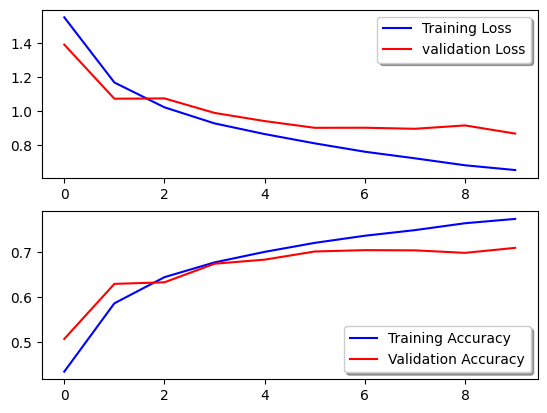

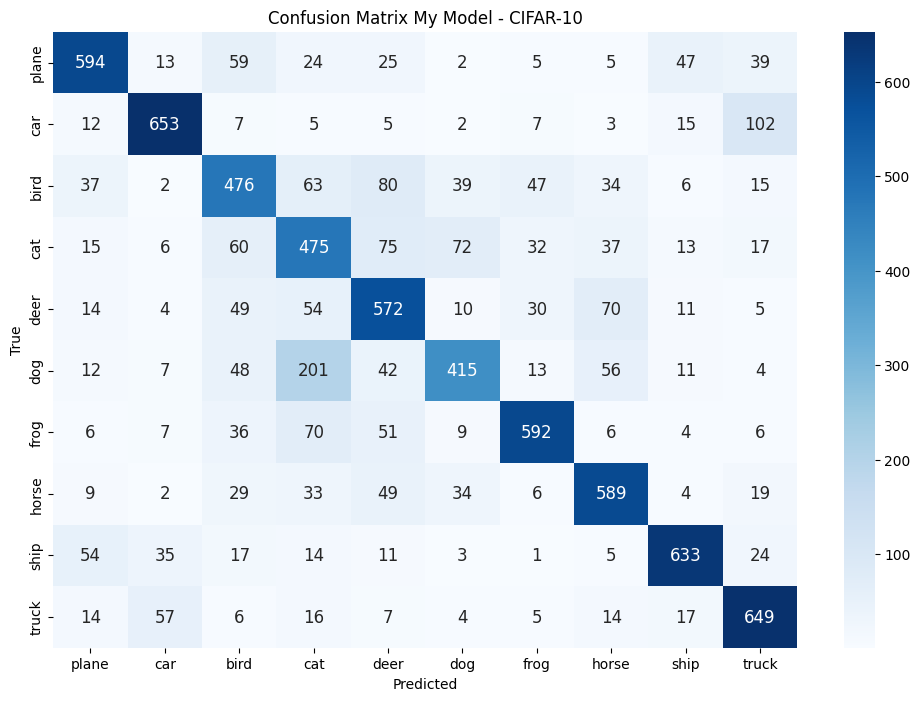

In [37]:
myModel()

In [4]:
# Load and preprocess the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0


y_train = to_categorical(y_train,10)
y_test = to_categorical(y_test,10)

X_test_img, X_valid_img, y_test_label, y_valid_label = train_test_split(
    x_test, y_test, test_size=0.5, random_state=42
)

In [32]:
def transfer_learning(
    base_model,
    num_classes,
    x_train,
    y_train,
    x_test,
    y_test,
    batch_size,
    epochs,
    inputs
):

    # Freeze the base model layers
    base_model.trainable = False

    # Add new classification layers on top of the base model
    x = GlobalAveragePooling2D(name = "Avg_pool")(x)
    x = Dense(256, activation="relu")(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    # Create the transfer learning model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    # Train the model
    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
    )
    return model, history


In [202]:
def transfer_learning_effNet():
    inputs = layers.Input(shape=(32, 32, 3))
    #x = img_augmentation(inputs)
    x = inputs
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    for layer in model.layers[:-6]:
        layer.trainable = False
    # Rebuild top
    x = GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    x = Dense(256, activation='relu',name ="dense_layer")(x)

    outputs = layers.Dense(10, activation="softmax", name="pred")(x)

    # # Fix the pre-trained biases
    # for layer in model.layers:
    #     if 'bn' in layer.name:
    #         layer.trainable = True
    #         layer.bias_initializer = Zeros()

    # Compile
    model = Model(inputs, outputs, name="EfficientNet")
    model.compile(
        optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [203]:
def transfer_learning_MobileNet():
    inputs = layers.Input(shape=(32, 32, 3))
    x = inputs
    model = MobileNet(weights="imagenet", input_tensor=x, include_top=False)

    # Freeze the pretrained weights
    for layer in model.layers[:-6]:
        layer.trainable = False

    x = GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = Dense(256, activation="relu", name="dense_layer")(x)
    outputs = layers.Dense(10, activation="softmax", name="pred")(x)

    # # Fix the pre-trained biases
    # for layer in model.layers:
    #     if 'bn' in layer.name:
    #         layer.trainable = True
    #         layer.bias_initializer =Zeros()

    # Compile
    model = Model(inputs, outputs, name="MobileNet")
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [190]:
def transfer_learning_VGG():
    inputs = layers.Input(shape=(32, 32, 3))
    x = inputs
    model = VGG16(weights="imagenet", input_tensor=x, include_top=False)

    # Freeze the pretrained weights
    for layer in model.layers[:-5]:
        layer.trainable = False

    x = GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = Dense(256, activation="relu", name="dense_layer")(x)
    outputs = layers.Dense(10, activation="softmax", name="pred")(x)

    # # Fix the pre-trained biases
    # for layer in model.layers:
    #     if 'bn' in layer.name:
    #         layer.trainable = True
    #         layer.bias_initializer =Zeros()

    # Compile
    model = Model(inputs, outputs, name="VGG16")
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [204]:
def transfer_learning_resNet():
    inputs = layers.Input(shape=(32, 32, 3))
    x = inputs
    model = ResNet50(weights="imagenet", input_tensor=x, include_top=False)

    # Freeze the pretrained weights
    for layer in model.layers[:-6]:
        layer.trainable = False

    x = GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = Dense(256, activation="relu", name="dense_layer")(x)
    outputs = layers.Dense(10, activation="softmax", name="pred")(x)

    # # Fix the pre-trained biases
    # for layer in model.layers:
    #     if 'bn' in layer.name:
    #         layer.trainable = True
    #         layer.bias_initializer =Zeros()

    # Compile
    model = Model(inputs, outputs, name="ResNet50")
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [206]:
model_effNet = transfer_learning_effNet()


In [207]:
model_mobNet = transfer_learning_MobileNet()


In [ ]:
model_VGG = transfer_learning_VGG()


In [208]:
model_resNet = transfer_learning_resNet()

In [209]:
model_effNet.summary()


Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_77 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_72 (Rescaling)       (None, 32, 32, 3)    0           ['input_77[0][0]']               
                                                                                                  
 normalization_36 (Normalizatio  (None, 32, 32, 3)   7           ['rescaling_72[0][0]']           
 n)                                                                                               
                                                                                                  
 rescaling_73 (Rescaling)       (None, 32, 32, 3)    0           ['normalization_36[0][

In [210]:
model_mobNet.summary()


Model: "MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_78 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 16, 16, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 16, 16, 32)       128       
 ation)                                                  

In [196]:
model_VGG.summary()


Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_74 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [211]:
model_resNet.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_79 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_79[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [221]:
history_effNet = model_effNet.fit(x_train, y_train, epochs=4, verbose=2,validation_data=(x_test, y_test))


Epoch 1/4
1563/1563 - 190s - loss: 2.0898 - accuracy: 0.2136 - val_loss: 2.4780 - val_accuracy: 0.1205 - 190s/epoch - 122ms/step
Epoch 2/4
1563/1563 - 190s - loss: 2.0791 - accuracy: 0.2169 - val_loss: 2.4622 - val_accuracy: 0.1391 - 190s/epoch - 122ms/step
Epoch 3/4
1563/1563 - 202s - loss: 2.0690 - accuracy: 0.2223 - val_loss: 2.4387 - val_accuracy: 0.0968 - 202s/epoch - 129ms/step
Epoch 4/4
1563/1563 - 195s - loss: 2.0628 - accuracy: 0.2236 - val_loss: 3.9715 - val_accuracy: 0.1491 - 195s/epoch - 125ms/step


In [213]:
history_mobNet = model_mobNet.fit(x_train, y_train, epochs=8, verbose=2,validation_data=(x_test, y_test))


Epoch 1/8
1563/1563 - 181s - loss: 1.3246 - accuracy: 0.5411 - val_loss: 1.2136 - val_accuracy: 0.5783 - 181s/epoch - 116ms/step
Epoch 2/8
1563/1563 - 178s - loss: 1.0726 - accuracy: 0.6218 - val_loss: 1.1291 - val_accuracy: 0.6057 - 178s/epoch - 114ms/step
Epoch 3/8
1563/1563 - 177s - loss: 0.9684 - accuracy: 0.6581 - val_loss: 1.1378 - val_accuracy: 0.6125 - 177s/epoch - 113ms/step
Epoch 4/8
1563/1563 - 188s - loss: 0.8638 - accuracy: 0.6934 - val_loss: 1.1489 - val_accuracy: 0.6052 - 188s/epoch - 121ms/step
Epoch 5/8
1563/1563 - 211s - loss: 0.7705 - accuracy: 0.7240 - val_loss: 1.2119 - val_accuracy: 0.6052 - 211s/epoch - 135ms/step
Epoch 6/8
1563/1563 - 200s - loss: 0.6702 - accuracy: 0.7592 - val_loss: 1.2741 - val_accuracy: 0.6054 - 200s/epoch - 128ms/step
Epoch 7/8
1563/1563 - 291s - loss: 0.5805 - accuracy: 0.7927 - val_loss: 1.3546 - val_accuracy: 0.6002 - 291s/epoch - 186ms/step
Epoch 8/8
1563/1563 - 210s - loss: 0.5059 - accuracy: 0.8205 - val_loss: 1.5100 - val_accuracy: 0

In [200]:
history_VGG = model_VGG.fit(x_train, y_train, epochs=5, verbose=2,batch_size = 64,validation_data=(x_test, y_test))


Epoch 1/5
782/782 - 836s - loss: 1.0848 - accuracy: 0.6228 - val_loss: 0.8827 - val_accuracy: 0.6981 - 836s/epoch - 1s/step
Epoch 2/5
782/782 - 838s - loss: 0.8040 - accuracy: 0.7231 - val_loss: 0.8079 - val_accuracy: 0.7204 - 838s/epoch - 1s/step
Epoch 3/5
782/782 - 928s - loss: 0.6987 - accuracy: 0.7597 - val_loss: 0.7701 - val_accuracy: 0.7351 - 928s/epoch - 1s/step
Epoch 4/5
782/782 - 921s - loss: 0.6110 - accuracy: 0.7888 - val_loss: 0.7721 - val_accuracy: 0.7396 - 921s/epoch - 1s/step
Epoch 5/5
782/782 - 1103s - loss: 0.5490 - accuracy: 0.8064 - val_loss: 0.8048 - val_accuracy: 0.7339 - 1103s/epoch - 1s/step


In [214]:
history_resNet = model_resNet.fit(x_train, y_train, epochs=6, verbose=2,batch_size = 64,validation_data=(x_test, y_test))


Epoch 1/6
782/782 - 304s - loss: 1.7806 - accuracy: 0.3700 - val_loss: 1.6528 - val_accuracy: 0.4110 - 304s/epoch - 388ms/step
Epoch 2/6
782/782 - 307s - loss: 1.6082 - accuracy: 0.4320 - val_loss: 1.5679 - val_accuracy: 0.4449 - 307s/epoch - 393ms/step
Epoch 3/6
782/782 - 332s - loss: 1.5394 - accuracy: 0.4532 - val_loss: 1.5501 - val_accuracy: 0.4579 - 332s/epoch - 424ms/step
Epoch 4/6
782/782 - 342s - loss: 1.4941 - accuracy: 0.4663 - val_loss: 1.5151 - val_accuracy: 0.4573 - 342s/epoch - 437ms/step
Epoch 5/6
782/782 - 338s - loss: 1.4486 - accuracy: 0.4869 - val_loss: 1.5198 - val_accuracy: 0.4647 - 338s/epoch - 432ms/step
Epoch 6/6
782/782 - 411s - loss: 1.4093 - accuracy: 0.5027 - val_loss: 1.4741 - val_accuracy: 0.4755 - 411s/epoch - 525ms/step


In [72]:
def plotting_loss_accuracy(history,name):
    # Show Loss and Accuracy Plots
    fig, ax = plt.subplots(2, 1)

    ax[0].plot(history.history["loss"], color="b", label="Training Loss")
    ax[0].plot(
        history.history["val_loss"], color="r", label="validation Loss", axes=ax[0]
    )
    ax[0].set_title(f"Loss of {name} model")

    legend = ax[0].legend(loc="best", shadow=True)


    ax[1].plot(history.history["accuracy"], color="b", label="Training Accuracy")
    ax[1].plot(history.history["val_accuracy"], color="r", label="Validation Accuracy")
    legend = ax[1].legend(loc="best", shadow=True)
    ax[1].set_title(f"Accuracy of {name} model")
    plt.tight_layout()
    plt.show()
    

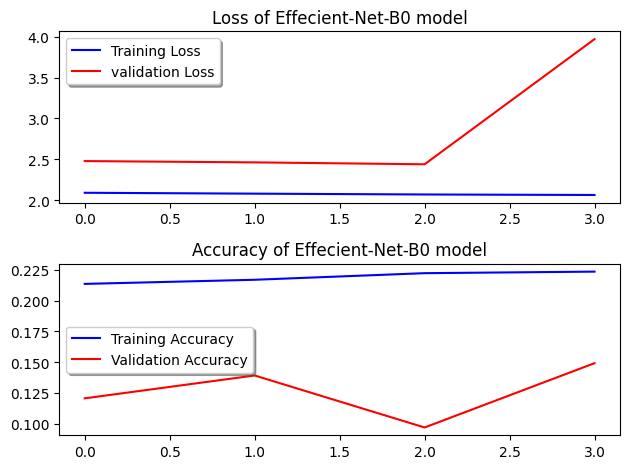

In [222]:
plotting_loss_accuracy(history_effNet,"Effecient-Net-B0")


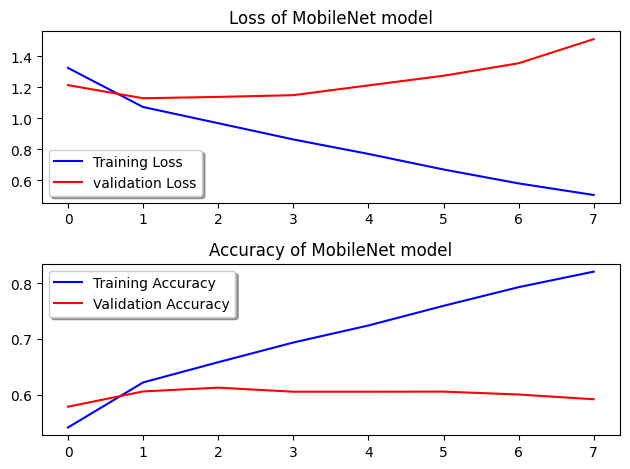

In [216]:
plotting_loss_accuracy(history_mobNet,"MobileNet")


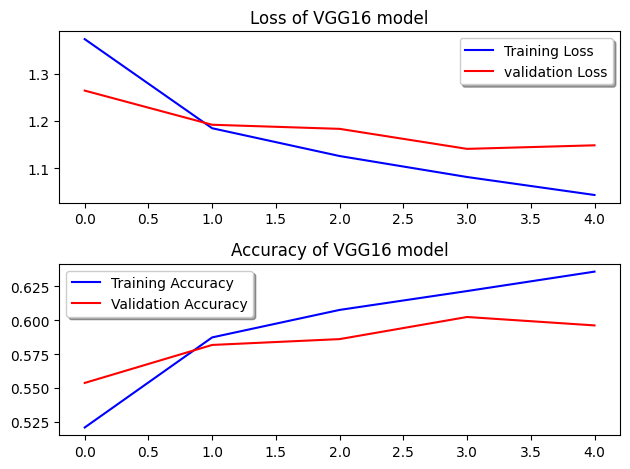

In [160]:
plotting_loss_accuracy(history_VGG,"VGG16")


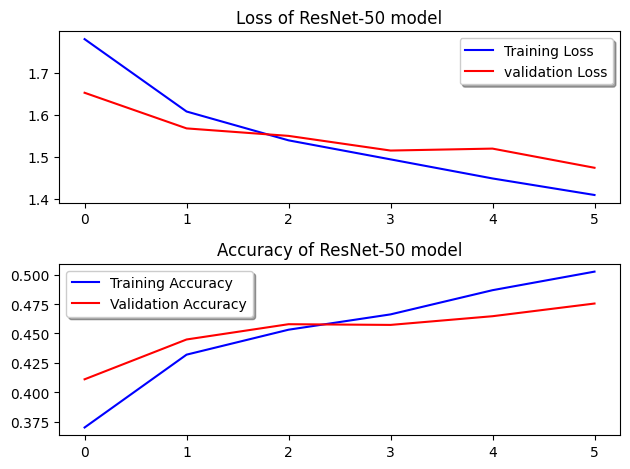

In [217]:
plotting_loss_accuracy(history_resNet,"ResNet-50")

In [21]:

def testing_model(model,class_names,name):
#Evaluate the model
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    print("Test accuracy:", test_accuracy)
    print("Test loss:", test_loss)

    y_pred = model.predict(x_test)
    # for each sample image in test dataset select class label with highest probability
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)


    # Compute confusion matrix
    confusion_mtx = confusion_matrix(y_true, y_pred)

# Display confusion matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        confusion_mtx,
        annot=True,
        cmap="Blues",
        fmt="d",
        annot_kws={"size": 12},
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix using {name} model - CIFAR-10")
    plt.show()


313/313 [==============================] - 26s 83ms/step - loss: 3.9715 - accuracy: 0.1491
Test accuracy: 0.14910000562667847
Test loss: 3.971515655517578
313/313 [==============================] - 22s 70ms/step


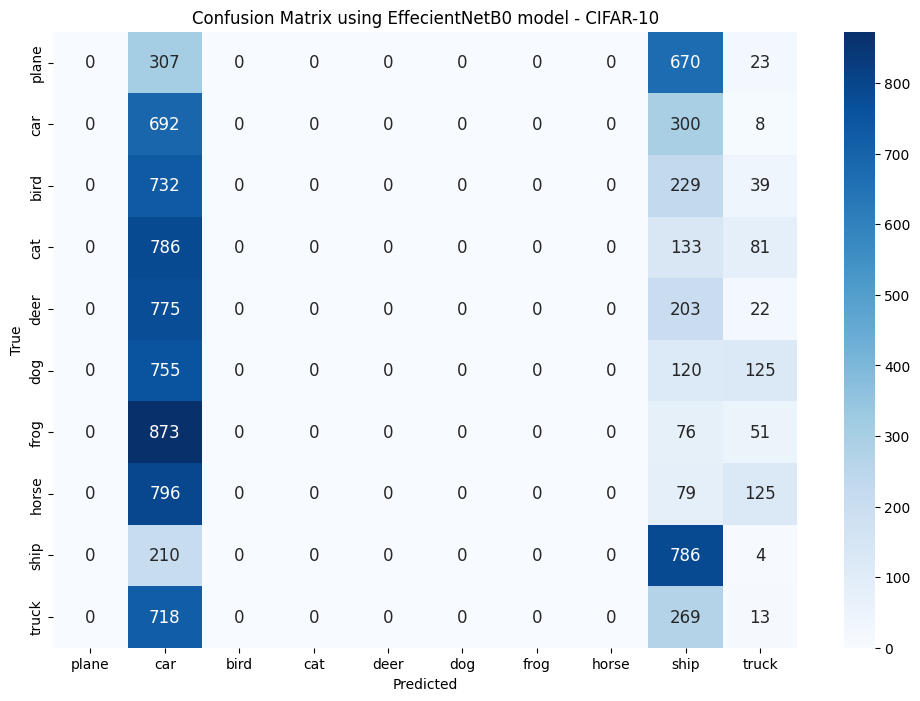

In [223]:
testing_model(model_effNet,class_names,"EffecientNetB0")


313/313 [==============================] - 11s 35ms/step - loss: 1.5100 - accuracy: 0.5917
Test accuracy: 0.59170001745224
Test loss: 1.5100024938583374
313/313 [==============================] - 13s 42ms/step


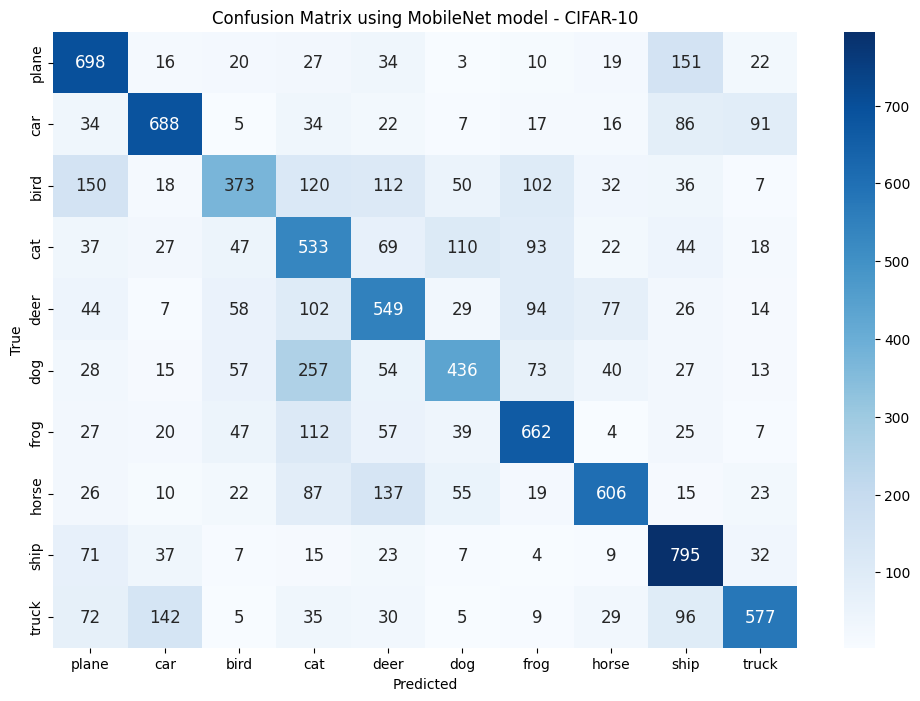

In [224]:
testing_model(model_mobNet,class_names,"MobileNet")


313/313 [==============================] - 53s 169ms/step - loss: 1.1486 - accuracy: 0.5961
Test accuracy: 0.5960999727249146
Test loss: 1.148597240447998
313/313 [==============================] - 53s 167ms/step


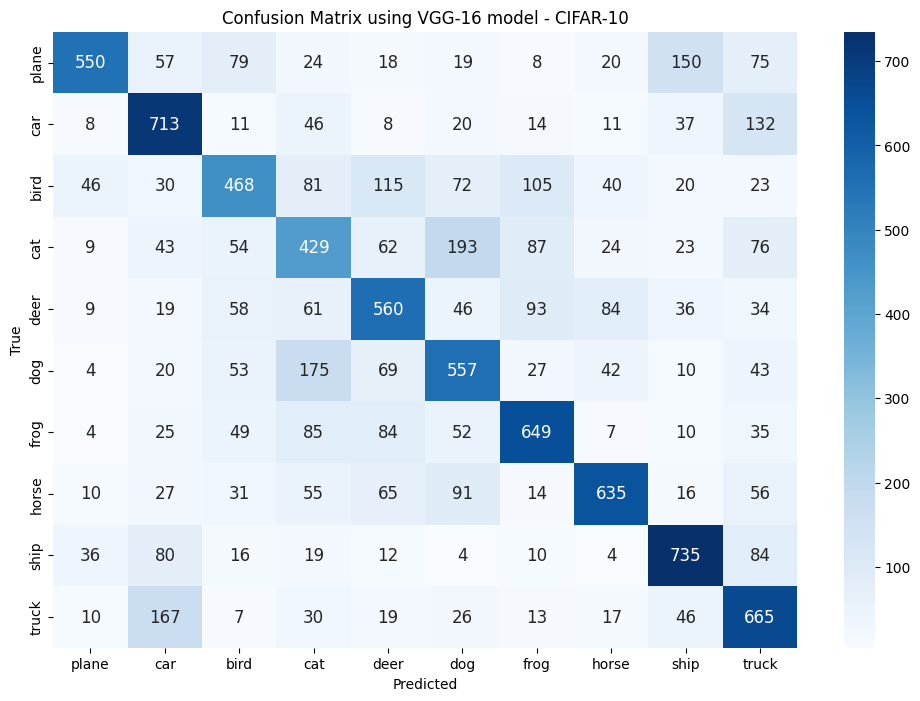

In [161]:
testing_model(model_VGG,class_names,"VGG-16")


313/313 [==============================] - 43s 137ms/step - loss: 1.4741 - accuracy: 0.4755
Test accuracy: 0.4754999876022339
Test loss: 1.474073886871338
313/313 [==============================] - 49s 149ms/step


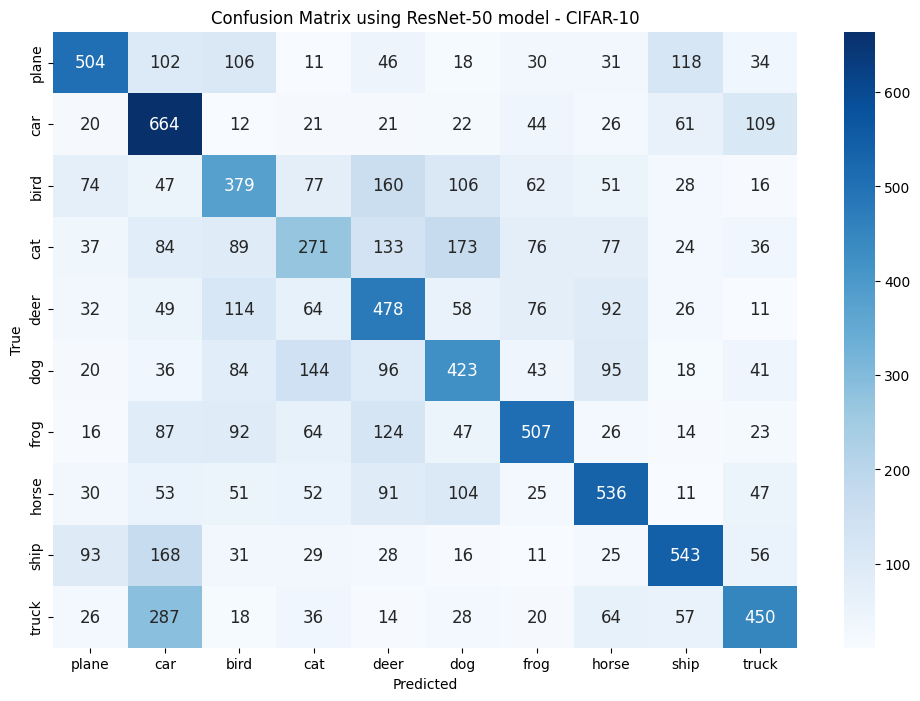

In [220]:
testing_model(model_resNet,class_names,"ResNet-50")